## Loading the required Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
warnings.simplefilter("ignore")

In [3]:
os.chdir('C:/Users/barun/Desktop/SB/Home-Credit-Project/home_credit_datasets')

## Loading the required datasets

In [4]:
df_train = pd.read_csv('application_train.csv')
df0 = df_train.copy()

In [5]:
dfinal_v1 = pd.read_csv('dfinal_updated.csv')

In [6]:
dfinal = dfinal_v1.copy()

In [7]:
dfinal.shape

(307511, 259)

## In this section I define helper functions to do the following

- Returning variables having missing values
- Returtning columns that will have less than 45% of missing values
- Imputing numerical values
- Imputing categorical values
- one-hot encoding for categorical variables
- Changing the data type of categorical variables to numeric before passing them to ML model
- Scaling the variables
- Splitting the variables and performing feature engineering while preventing data leakage

In [8]:
# This function returns the variables/columns having missing values
def vars_with_na(df,cols):
    
    var_na_list = []
    
    for var in cols:
        if df[var].isnull().sum() > 0:
            var_na_list.append(var)
    
    return var_na_list

In [9]:
# This function will return only those colums (numerical or categorical) with less than 45% of missing values
def listcols(df,cols):    
    l = df[cols].isna().sum() > df.shape[0]*0.45
    l = l[l == False]
    missing_cols_less_45 = list(set(cols).intersection(set(l.index)))
    return missing_cols_less_45

In [10]:
# Function to impute numerical variables with their respective means
def impute_num_vars(X_train,X_test,var_na_list):
    for var in var_na_list:

        # calculate the mean using the train set
        mean_val = X_train[var].mean()
        X_train[var] = X_train[var].fillna(mean_val)
        X_test[var] = X_test[var].fillna(mean_val)

In [11]:
# Function to impute categorical variables
def impute_cat_vars(X_train, X_test,var_na_list):
    
    for var in var_na_list:
        # fill the missing values with the string "Missing"
        X_train[var] = X_train[var].fillna("Missing")
        X_test[var] = X_test[var].fillna("Missing")

In [12]:
# function to do one hot encoding for categorical variables
def catdummies(X_train, cat_cols):
    
    X_train[cat_cols]= X_train[cat_cols].astype('category')
    dfdum = pd.get_dummies(X_train[cat_cols])
    print(dfdum.shape)
    dfcat = pd.concat([X_train[cat_cols], dfdum], axis = 1)
    dfcat.drop(columns = cat_cols, inplace = True)
    
    return dfcat

In [13]:
# changing the one hot encoding values to integers before passing them to the machine learning model
def change_dum_to_int(df, final_cat_cols):
    
    for col in final_cat_cols:
        df[col] = df[col].astype(np.int64)
    
    return df

In [14]:
# Scaling the variables before passing the data to the machine learning models

def varscaling(X_train, X_test):
    

    train_vars = [var for var in X_train.columns if var not in ['SK_ID_CURR', 'TARGET']]

    #count number of variables
    len(train_vars)
    
    scaler = MinMaxScaler()

    #fit the scaler to the train set
    scaler.fit(X_train[train_vars]) 

    # transform the train and test set
    X_train[train_vars] = scaler.transform(X_train[train_vars])

    X_test[train_vars] = scaler.transform(X_test[train_vars])

In [15]:
# This function will divide the data into train and test in such a way that feature engineering doesn't lead to
# data leakage

def train_test_final(dfinal):
    
    #Regardless of the original data type, segregating columns which are categorical in nature
    
    cat_col_list = ['NAME_CONTRACT_TYPE','NAME_TYPE_SUITE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
                       'CNT_CHILDREN','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE',
                       'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                      'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                       'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE','FLAG_DOCUMENT_2',
                       'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8',
                       'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
                       'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
                       'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','WALLSMATERIAL_MODE','HOUSETYPE_MODE',
            'FONDKAPREMONT_MODE','EMERGENCYSTATE_MODE','OCCUPATION_TYPE']
    
    cat_cols = []
    
    # Building the initial list of categorical variables in the data set
    
    for col in dfinal.columns:
        
        if col in cat_col_list:
            cat_cols.append(col)
        
    
    # Building the initial list of numerical variables in the data set
    
    num_cols = set(dfinal.columns).difference(set(cat_cols))
    num_cols = list(num_cols)
    
    # removing the target and id columns from the data set if available
    
    if 'TARGET' in num_cols:
        num_cols.remove('TARGET')
        
    if 'SK_ID_CURR' in num_cols:
        num_cols.remove('SK_ID_CURR')
    
    # building the list of numerical and categorical varibles that has less than 45% of missing variables
    
    num_cols_45 = listcols(dfinal, num_cols)
    cat_cols_45 = listcols(dfinal,cat_cols)
    
    
    # Building the data set that oncly contains the variables consisting less than 45% missing values
    
    dfinal_45 = dfinal[num_cols_45 + cat_cols_45]
    
    
    # Splitting the above dataset into test and train
    
    X_train, X_test, y_train, y_test = train_test_split(dfinal_45,
                                                    dfinal['TARGET'],
                                                    test_size=0.2,
                                                    # we are setting the seed here:
                                                    random_state=0) 
    
    # numerical coding for WEEKDAY_APPR_PROCESS_START_x variable
    
    if 'WEEKDAY_APPR_PROCESS_START_x' in dfinal_45.columns:
        
    
        X_train['WEEKDAY_APPR_PROCESS_START_x'] = X_train['WEEKDAY_APPR_PROCESS_START_x'].map({'SUNDAY':0,'MONDAY': 1, 'TUESDAY':2, 'WEDNESDAY':3,'THURSDAY':4,
                                          'FRIDAY': 5, 'SATURDAY' : 6})

        X_test['WEEKDAY_APPR_PROCESS_START_x'] = X_test['WEEKDAY_APPR_PROCESS_START_x'].map({'SUNDAY':0,'MONDAY': 1, 'TUESDAY':2, 'WEDNESDAY':3,'THURSDAY':4,
                                          'FRIDAY': 5, 'SATURDAY' : 6})
        
    #print("Stage 1 Completed")
    
    # imputing the numerical variables that had less than 45% of missing valiues for both train and test data set
    
    vars_na_num_train = vars_with_na(X_train,num_cols_45)
    impute_num_vars(X_train, X_test,vars_na_num_train)
    
    #Imputing the categorical variables that had less than 45% of missing valiues for both train and test data set
    
    vars_na_cat_train = vars_with_na(X_train,cat_cols_45)
    impute_cat_vars(X_train,X_test,vars_na_cat_train)
    
    #print("stage 2")
    
    # One hot encoding for categorical variables for both train and test data sets
    
    dfcat_train = catdummies(X_train, cat_cols_45)
    dfcat_test = catdummies(X_test, cat_cols_45)
    
    #print("stage 3 completed")
    
    # Adding colums from the test data set that are part of train dataset but not present in test data set
    # to make the test data set consumable for prediction
    
    missing_test_cols = list(set(dfcat_train.columns).difference(set(dfcat_test.columns)))
    for col in missing_test_cols:
        dfcat_test[col] = 0

    
    #print("stage 4 completed")
    
    # deleting columns from the test data that are not part of train data set to test data set consumable 
    #for model prediction
    
    extra_test_cols = set(dfcat_test.columns). difference (set(dfcat_train.columns))
    dfcat_test.drop(columns = extra_test_cols, inplace = True)
    
    #print("stage 5 completed")
    
   # Building the final training data set by concatenating numerical and categorical columns

    X_train = pd.concat([X_train[num_cols_45], dfcat_train], axis = 1)
    X_test = pd.concat([X_test[num_cols_45], dfcat_test], axis = 1)
    
    #print("stage 6 completed")
    
    # Changing the data type of encoded categorical varibale to integer
    
    final_dum_cols = set(X_train.columns).difference(set(num_cols_45))
    
    X_train = change_dum_to_int(X_train, final_dum_cols)
    X_test = change_dum_to_int(X_test, final_dum_cols)
    
    #print("stage 7 completed")
     
    # Scaling the train and test data set 
    
    varscaling(X_train,X_test)
    
    print("Final Shape of X_train after scaling is: {}".format(X_train.shape))
    print("Final Shape of X_test after scaling is: {}".format(X_test.shape))
    
    # Doing a check whether train and test data set have the same columns
    
    if sorted(X_train.columns) == sorted(X_test.columns):
        print("Train and Test data sets have the same columns")
        X_test = X_test[X_train.columns]
    else:
        print("Train and Test data sets are different")
    
    return (X_train, X_test, y_train, y_test)

In [16]:
# Split the data into train and test by calling the train_test_final function
X_train, X_test, y_train, y_test = train_test_final(dfinal)

(246008, 203)
(61503, 196)
Final Shape of X_train after scaling is: (246008, 364)
Final Shape of X_test after scaling is: (61503, 364)
Train and Test data sets have the same columns


In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(246008, 364)
(246008,)
(61503, 364)
(61503,)


## Feature Selection by feature importance returned by Random Forest

In [18]:
# Splitting the feature and target variables into train and test sets

from sklearn.model_selection import train_test_split
#feature_df_train, feature_df_test, target_df_train, target_df_test = train_test_split(X_train,y_train ,test_size=0.33, random_state=42)

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators = 100)

print(rf)

rf.fit(X_train, y_train)

feature_imp = dict(zip(feat_labels, rf.feature_importances_))
feature_imp_sort = sorted(feature_imp.items(), key = lambda feature_imp : feature_imp[1], reverse = True)
feature_imp_sort = dict(feature_imp_sort)
topcols = list(feature_imp_sort.keys())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [19]:
y_train

307429    0
30132     0
188859    0
225559    0
138524    0
         ..
122579    0
304137    0
152315    1
117952    1
305711    0
Name: TARGET, Length: 246008, dtype: int64

## Creating a sample to be used in the grid search function to determine the best values of hyperparameters for a particular model  

In [20]:
X_train_org1, X_sample, y_train1, y_sample = train_test_split(X_train, y_train, shuffle = True, test_size = 0.1, stratify = y_train, random_state = 0) 

In [21]:
X_sample.shape

(24601, 364)

In [22]:
y_sample.shape

(24601,)

In [23]:
y_sample.value_counts()

0    22604
1     1997
Name: TARGET, dtype: int64

In [24]:
y_sample.value_counts(normalize = True)

0    0.918824
1    0.081176
Name: TARGET, dtype: float64

## In this section I define functions to do the following

- Gridsearch to find the best hyper parameters
- Comparing the performance of a model w.r.t different number of top features passed to the model
- Plotting the performance(roc) of a model w.r.t different number of top features passed to the model
- Generating a comprehensive report of the final model 



In [25]:
# function to run gridsearch on the sample data set to determine best parameters
def bestmodel(modelname, params):
    
    #from sklearn.model_selection import StratifiedKFold
    
    print(modelname)
    
    # Determing the best set of params using grid search
    # There would be some amount of data leakage for using GridsearchCV as is. In the next iteration of code have to customize the code to address the issue.
    
    clf = GridSearchCV(modelname, 
                   params,
                   n_jobs=-1, 
                   cv= 5, 
                   scoring='roc_auc', 
                   verbose=2, 
                   refit='AUC')
    
    model_train = clf.fit(X_sample, y_sample)
    
    return model_train

In [26]:
# This function is going to compare the model performance for different number of features passed w.r.t feature importance

def featurecompare(model,num):
    
    print('Number of subfeatures for this iteration is {}'.format(num))
    
    X_train_subfeatures = X_train[topcols[0:num]]
    y_train_subfeatures = y_train
                                  
    X_test_subfeatures = X_test[topcols[0:num]]
    y_test_subfeatures = y_test
    
    print('Trainig Dataset Shape : {}'.format(X_train_subfeatures.shape))
    print('Test Dataset Shape : {}'.format(X_test_subfeatures.shape))             
    
    #pd.concat([X_train[topcols[0:num]], y_train], axis = 1)
    model = model.fit(X_train_subfeatures, y_train_subfeatures)

    y_predict_train_model = model.predict(X_train_subfeatures)

    y_predictprob_train_model = model.predict_proba(X_train_subfeatures)
    y_predict_train_model = pd.DataFrame(y_predict_train_model, columns = ['TARGET'])
    y_predict_train_model['PROF1'] = y_predictprob_train_model[:][:,1]
    y_predict_train_model.head()

    y_actual_train_model = pd.DataFrame(y_train_subfeatures,columns = ['TARGET']).reset_index()

    roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])

    auroc_train = roc_auc_score(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    
    print('The AUROC score for training data set is: {:0.5f}'.format(auroc_train))


    y_predict_test_model = model.predict(X_test_subfeatures)

    y_predictprob_test_model = model.predict_proba(X_test_subfeatures)
    y_predict_test_model = pd.DataFrame(y_predict_test_model, columns = ['TARGET'])
    y_predict_test_model['PROF1'] = y_predictprob_test_model[:][:,1]
    y_predict_test_model.head()


    y_actual_test_model = pd.DataFrame(y_test_subfeatures,columns = ['TARGET']).reset_index()

    roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    
    
    auroc_test = roc_auc_score(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    
    print('The AUROC score on the test data set is: {:0.5f}'.format(auroc_test))
    
    return  [auroc_train, auroc_test]

In [27]:
# printing and comparing auroc score of the models with different number of features passed w.r.t feature importance
def auccompare(model,numoffeatures):

    auroc_model = []

    for ndx, num in enumerate(numoffeatures):

        auroc = featurecompare(model, num)
        print('Iteration number {} is now complete\n\n'. format(ndx+1))
        auroc_model.append(auroc)

    print('All Iterations are now complete\n'. format(ndx))
    print("Printing the train and corresponding test scores of each iteration\n")
    print(auroc_model)
    print('\n')
    return auroc_model

In [28]:
# Displaying the graph comparing the auc score for a model with different number of features
def roccompareplot(modelname,numoffeatures,auroc_train,auroc_test):
    
    plt.suptitle("Train and Test AUROC Comparison for {}".format(modelname),y=1.05)
    plt.plot(numoffeatures, auroc_train, c = 'g', label = 'Train Score')
    plt.plot(numoffeatures, auroc_test, c = 'b', label = 'Test Score')
    plt.legend(loc = 'lower right')
    plt.xlabel('Number Of Features')
    plt.ylabel('AUROC')

In [29]:
# function to display a comprehensive report on the performance of a model w.r.t different number of features paased to it,
#to help choose the final model
def modeldetails(model):
    
    modelname = str(model.best_estimator_).split('(')[0]
    print('Printing the mean test scores for {} model'.format(modelname))
    print(model.cv_results_['mean_test_score'])
    print('\n')

    print('Printing the best parameters for the grid search performed on {} as the base model'.format(modelname))
    print(model.best_params_)
    print('\n')

    print('Printing the best scores returned by the grid search performed on {} as the base model'.format(modelname))
    print(model.best_score_)
    print('\n')


    numoffeatures = [50,100,150,200,250,300,365]
    
    print('Comparing the performance of the best {} model with different number of features....\n'.format(modelname))

    auroc_model = auccompare(model.best_estimator_,numoffeatures)

    auroc_train_model = [n[0] for n in auroc_model]
    auroc_test_model = [n[1] for n in auroc_model]


    roccompareplot(modelname,numoffeatures, auroc_train_model, auroc_test_model)

In [30]:
# function for generating a comprehensive report on the performance of a final chosen model
def finalmodelperformance(numofoptfet,model_bestparam,tr):


    #X_train_model_final, X_test_model_final, y_train_model_final, y_test_model_final = train_test_split(dfet[topcols[0:numofoptfet]],df0['TARGET'], shuffle = True, test_size = 0.33, stratify = df0['TARGET'])

    X_train_model_final = X_train[topcols[0:numofoptfet]]
    y_train_model_final = y_train
    
    X_test_model_final = X_test[topcols[0:numofoptfet]]
    y_test_model_final = y_test
    
    print("Train Feature Data Shape :" + str(X_train_model_final.shape))
    print("Test Feature Data Shape :" + str(X_test_model_final.shape))
    print("Train Target Data Shape :" + str(y_train_model_final.shape))
    print("Test Target Data Shape :" + str(y_test_model_final.shape))
    print('\n')

    model_final = model_bestparam.fit(X_train_model_final,y_train_model_final)

    y_predict_train_model = model_final.predict(X_train_model_final)

    y_predictprob_train_model = model_final.predict_proba(X_train_model_final)
    y_predict_train_model = pd.DataFrame(y_predict_train_model, columns = ['TARGET'])
    y_predict_train_model['PROF1'] = y_predictprob_train_model[:][:,1]
    y_predict_train_model.head()

    y_actual_train_model = pd.DataFrame(y_train_model_final,columns = ['TARGET']).reset_index()
    #tr = 0.5
    y_predict_train_model['PTARGET'] = np.where(y_predict_train_model['PROF1'] > tr, 1, 0)
    
    cm_model_train = confusion_matrix(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])
    print("Train Data Accuracy Score : %0.4f" % accuracy_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET']))
    print("Train Data Precision Score : %0.4f" % precision_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])) # tp / (tp + fp)
    print("Train Data Recall Score : %0.4f" % recall_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])) # tp / (tp + fn)
    print(("Train Data F1 Score : %0.4f" % f1_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])))

    print('\n')
    print('Train Data Confusion Matrix\n')
    dfconfusion = pd.DataFrame(cm_model_train, index = ('Actual Non-Default', 'Actual Default'), columns = ('Predicted Non-Default', 'Predicted Default'))
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(dfconfusion, annot = True, fmt='g')
    plt.yticks(rotation = 0)
    plt.show()
    
    print('\n')
    print('Train Data ROC Curve\n')
    roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    sns.set()
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
    print('Train Data AUROC\n')
    AUROC_train = roc_auc_score(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    print("%0.4f" % AUROC_train)
    print('\n')
    
    
    y_predict_test_model = model_final.predict(X_test_model_final)

    y_predictprob_test_model = model_final.predict_proba(X_test_model_final)
    y_predict_test_model = pd.DataFrame(y_predict_test_model, columns = ['TARGET'])
    y_predict_test_model['PROF1'] = y_predictprob_test_model[:][:,1]
    y_predict_test_model.head()

    y_actual_test_model = pd.DataFrame(y_test_model_final,columns = ['TARGET']).reset_index()
    #tr = 0.5
    y_predict_test_model['PTARGET'] = np.where(y_predict_test_model['PROF1'] > tr, 1, 0)

    cm_model_test = confusion_matrix(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])
    print("Test Data Accuracy Score : %0.4f" % accuracy_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET']))
    print("Test Data Precision Score : %0.4f" % precision_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])) # tp / (tp + fp)
    print("Test Data Recall Score : %0.4f" % recall_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])) # tp / (tp + fn)
    print(("Test Data F1 Score : %0.4f" % f1_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])))

    
    print('\n')
    print('Test Data Confusion Matrix\n')
    dfconfusion = pd.DataFrame(cm_model_test, index = ('Actual Non-Default', 'Actual Default'), columns = ('Predicted Non-Default', 'Predicted Default'))
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(dfconfusion, annot = True, fmt='g')
    plt.yticks(rotation = 0)
    plt.show()
    #print("Test Data Accuracy: %0.4f" % accuracy_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET']))

    print('\n')
    print('Test Data ROC Curve\n')
    roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    sns.set()
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
    print('Test Data AUROC\n')
    AUROC_test = roc_auc_score(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    print("%0.4f" % AUROC_test)
    
    return [AUROC_train,AUROC_test,cm_model_train,cm_model_test]

### Running Gridsearch on a Logistic Regression Model

In [33]:
start_time_logit = time.time()
model_logit = LogisticRegression()
params_logit = {'C': [0.001,0.01,0.1,1,10,100],
                'penalty' : ['l1','l2']}
model_logit_best = bestmodel(model_logit,params_logit)
end_time_logit = time.time()
time_taken_logit = end_time_logit - start_time_logit
print("The total time taken to find the LR model with the best parameters is --- %s seconds ---" % (time_taken_logit))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


The total time taken to find the LR model with the best parameters is --- 65.17075634002686 seconds ---


In [34]:
model_logit_best.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Running Gridsearch on a Random Forest Model

In [96]:
start_time_rf = time.time()
model_rf = RandomForestClassifier()
params_rf = {'n_estimators': [200, 400,600,800],
             'max_leaf_nodes': [50, 75, 100,200],
             'max_features' : ['auto','sqrt',0.25],
             'min_samples_leaf': [50, 100, 200, 300]}
model_rf_best = bestmodel(model_rf, params_rf)
end_time_rf = time.time()
time_taken_rf = end_time_rf - start_time_rf
print("The total time taken to find the RF model with the best parameters is --- %s seconds ---" % (time_taken_rf))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 127.2min finished


The total time taken to find the RF model with the best parameters is --- 7676.820824146271 seconds ---


In [97]:
model_rf_best.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=200,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Running Gridsearch on a Light GBM Model

In [38]:
start_time_lgbm = time.time()
model_lgbm = lgb.LGBMClassifier()

params_lgbm = {
#'n_estimators': [40],
'num_leaves':[100,150,200,250],
'max_depth':[3,4,5,7],
'learning_rate':[.03,.05,0.08,1],
'max_bin':[100,200,300,400],
'boosting_type' : ['gbdt'],
'objective' : ['binary'],
#'random_state' : [501], # Updated from 'seed'
'colsample_bytree' : [0.65, 0.66],
'subsample' : [0.7,0.75],
'reg_alpha' : [1,1.2],
'reg_lambda' : [1,1.2,1.4]}

model_lgbm_best = bestmodel(model_lgbm, params_lgbm)
end_time_lgbm = time.time()
time_taken_lgbm = end_time_lgbm - start_time_lgbm
print("The total time taken to find the LGBM model with the best parameters is --- %s seconds ---" % (time_taken_lgbm))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Fitting 5 folds for each of 6144 candidates, totalling 30720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 71.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 79.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 88.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 99.0min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 110.4min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | 

The total time taken to find the LGBM model with the best parameters is --- 20257.918059825897 seconds ---


In [39]:
model_lgbm_best.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.65,
               importance_type='split', learning_rate=0.08, max_bin=300,
               max_depth=4, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=100,
               objective='binary', random_state=None, reg_alpha=1, reg_lambda=1,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=0)

### Running Gridsearch on a XGB Model

In [ ]:
start_time_xgb = time.time()
model_xgb = xgb.XGBClassifier()
params_xgb = {'gamma': [0.5, 0.7, 0.9, 1],
              'n_estimators':[800,1200,1400, 1600],
              'objective' : ['binary:logistic'],
              'learning_rate':[0.03,0.05,0.06,0.08],
              'max_depth': [2,4,6,8],
              'seed' : [27],
              'eval_metric': ['auc']}
model_xgb_best = bestmodel(model_xgb,params_xgb)
end_time_xgb = time.time()
time_taken_xgb = end_time_xgb - start_time_xgb
print("The total time taken to find the LGBM model with the best parameters is --- %s seconds ---" % (time_taken_xgb))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


### Evaluating Logistic Regression with best parameters with different # of top features

Printing the mean test scores for LogisticRegression model
[0.50124033 0.68000535 0.72080043 0.73044495 0.73757376 0.7445132
 0.74589553 0.74575539 0.74078779 0.74263598 0.7373758  0.73972104]


Printing the best parameters for the grid search performed on LogisticRegression as the base model
{'C': 1, 'penalty': 'l1'}


Printing the best scores returned by the grid search performed on LogisticRegression as the base model
0.7458955282659345


Comparing the performance of the best LogisticRegression model with different number of features....

Number of subfeatures for this iteration is 50
Trainig Dataset Shape : (246008, 50)
Test Dataset Shape : (61503, 50)
The AUROC score for training data set is: 0.73656
The AUROC score on the test data set is: 0.73942
Iteration number 1 is now complete


Number of subfeatures for this iteration is 100
Trainig Dataset Shape : (246008, 100)
Test Dataset Shape : (61503, 100)
The AUROC score for training data set is: 0.75096
The AUROC score on the test d

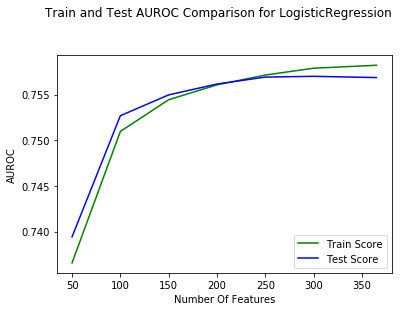

In [35]:
start_time_logit = time.time()
modeldetails(model_logit_best)
end_time_logit = time.time()
time_taken_logit = end_time_logit - start_time_logit
print("The total time taken to find the LR model with the optimum # of features is --- %s seconds ---" % (time_taken_logit))

### Running the Logistic Regresson Model (with best params) with top 200 features for optimum results

Train Feature Data Shape :(246008, 200)
Test Feature Data Shape :(61503, 200)
Train Target Data Shape :(246008,)
Test Target Data Shape :(61503,)


Train Data Accuracy Score : 0.9189
Train Data Precision Score : 0.5149
Train Data Recall Score : 0.0208
Train Data F1 Score : 0.0399


Train Data Confusion Matrix



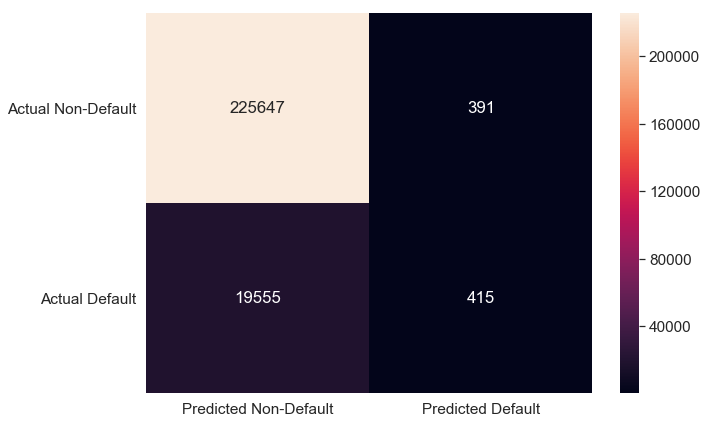



Train Data ROC Curve



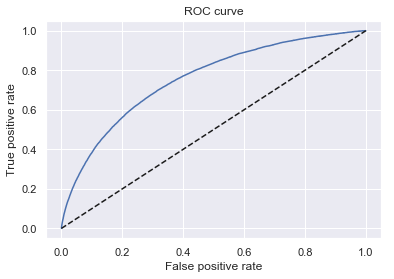

Train Data AUROC

0.7559


Test Data Accuracy Score : 0.9212
Test Data Precision Score : 0.5202
Test Data Recall Score : 0.0212
Test Data F1 Score : 0.0408


Test Data Confusion Matrix



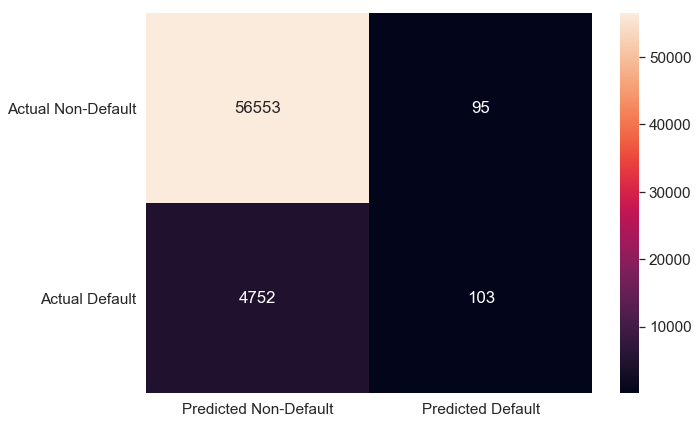



Test Data ROC Curve



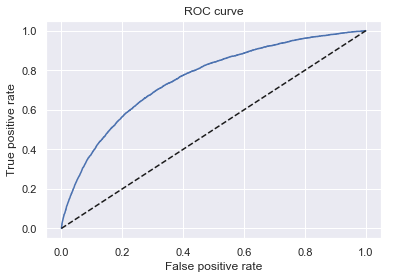

Test Data AUROC

0.7560


In [36]:
logit_finalmodel_matrix = finalmodelperformance(200,model_logit_best.best_estimator_, 0.5)

### Evaluating Random Forest model (with best parameters) with different # of features

Printing the mean test scores for RandomForestClassifier model
[0.73717992 0.7389955  0.73989667 0.74105376 0.7389772  0.74034623
 0.74082007 0.74056478 0.73812842 0.73855596 0.73926355 0.73948253
 0.73518932 0.73720114 0.73778135 0.73837234 0.74140129 0.74102862
 0.74179516 0.74229859 0.74086523 0.7411403  0.74249908 0.74234436
 0.73887725 0.73904292 0.73986544 0.74030058 0.73696221 0.73734958
 0.73738953 0.73723565 0.74030177 0.7433491  0.7421718  0.74312433
 0.74126868 0.74220093 0.74234896 0.74245576 0.73818583 0.74121262
 0.7408717  0.73976062 0.73461823 0.73709415 0.73835251 0.73825207
 0.74045777 0.74302599 0.74380087 0.74438529 0.74200828 0.74245752
 0.7426512  0.74228974 0.73816132 0.74028744 0.73975901 0.73996539
 0.73787039 0.73758139 0.73794836 0.73824591 0.73729703 0.74013655
 0.74063925 0.73978844 0.73803237 0.73973388 0.741183   0.74151664
 0.73775253 0.73844158 0.73926343 0.73938273 0.73704124 0.73761465
 0.73746376 0.73679733 0.73928241 0.74211531 0.74201434 0.74291559

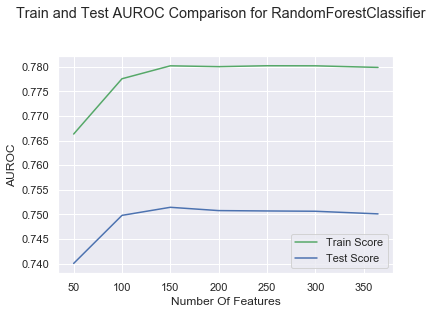

In [98]:
start_time_rf = time.time()
modeldetails(model_rf_best)
end_time_rf = time.time()
time_taken_rf = end_time_rf - start_time_rf
print("The total time taken to find the RF model with the optimum # of features is --- %s seconds ---" % (time_taken_rf))

### Running the Random Forest Model (with best params) with top 150 features for optimum results

Train Feature Data Shape :(246008, 150)
Test Feature Data Shape :(61503, 150)
Train Target Data Shape :(246008,)
Test Target Data Shape :(61503,)


Train Data Accuracy Score : 0.9188
Train Data Precision Score : 0.0000
Train Data Recall Score : 0.0000
Train Data F1 Score : 0.0000


Train Data Confusion Matrix



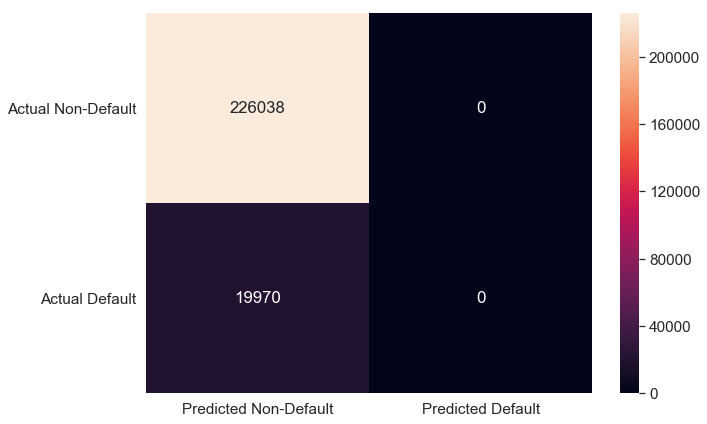



Train Data ROC Curve



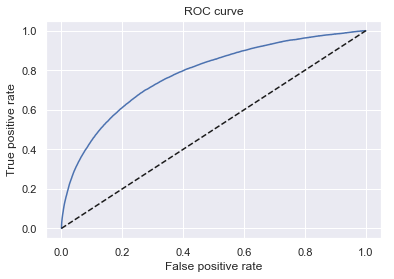

Train Data AUROC

0.7802


Test Data Accuracy Score : 0.9211
Test Data Precision Score : 0.0000
Test Data Recall Score : 0.0000
Test Data F1 Score : 0.0000


Test Data Confusion Matrix



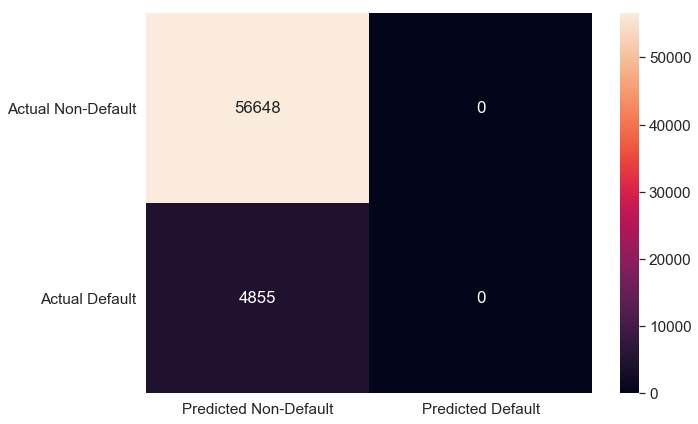



Test Data ROC Curve



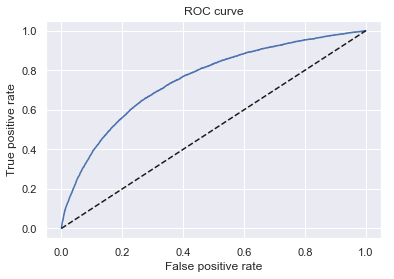

Test Data AUROC

0.7517


In [99]:
rf_finalmodel_matrix = finalmodelperformance(150,model_rf_best.best_estimator_,0.5)

### Evaluating Light GBM model (with best parameters) with different # of top features

Printing the mean test scores for LGBMClassifier model
[0.73739949 0.73739949 0.73776963 ... 0.66954318 0.66597367 0.66597367]


Printing the best parameters for the grid search performed on LGBMClassifier as the base model
{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.08, 'max_bin': 300, 'max_depth': 4, 'num_leaves': 100, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}


Printing the best scores returned by the grid search performed on LGBMClassifier as the base model
0.7515545987454142


Comparing the performance of the best LGBMClassifier model with different number of features....

Number of subfeatures for this iteration is 50
Trainig Dataset Shape : (246008, 50)
Test Dataset Shape : (61503, 50)
The AUROC score for training data set is: 0.76679
The AUROC score on the test data set is: 0.75492
Iteration number 1 is now complete


Number of subfeatures for this iteration is 100
Trainig Dataset Shape : (246008, 100)
Test Dataset Shap

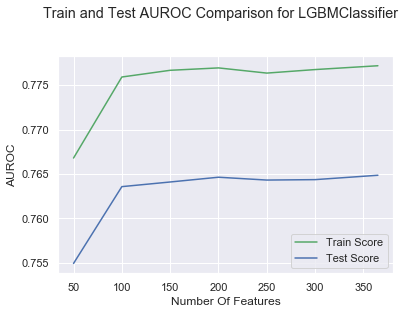

In [40]:
start_time_lgbm = time.time()
modeldetails(model_lgbm_best)
end_time_lgbm = time.time()
time_taken_lgbm = end_time_lgbm - start_time_lgbm
print("The total time taken to find the LGBM model with the optimum # of features is --- %s seconds ---" % (time_taken_lgbm))

### Running the Light GBM (with best params) with 150 top features for optimum results

Train Feature Data Shape :(246008, 150)
Test Feature Data Shape :(61503, 150)
Train Target Data Shape :(246008,)
Test Target Data Shape :(61503,)


Train Data Accuracy Score : 0.9195
Train Data Precision Score : 0.6900
Train Data Recall Score : 0.0153
Train Data F1 Score : 0.0299


Train Data Confusion Matrix



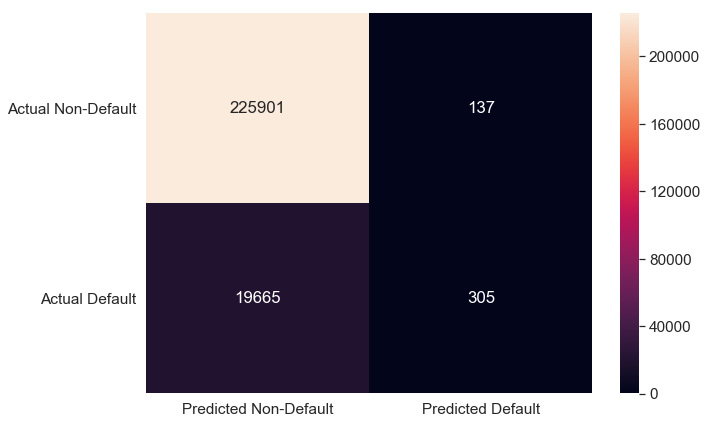



Train Data ROC Curve



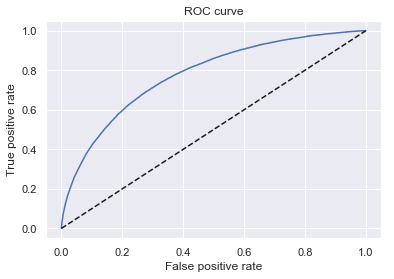

Train Data AUROC

0.7767


Test Data Accuracy Score : 0.9212
Test Data Precision Score : 0.5514
Test Data Recall Score : 0.0122
Test Data F1 Score : 0.0238


Test Data Confusion Matrix



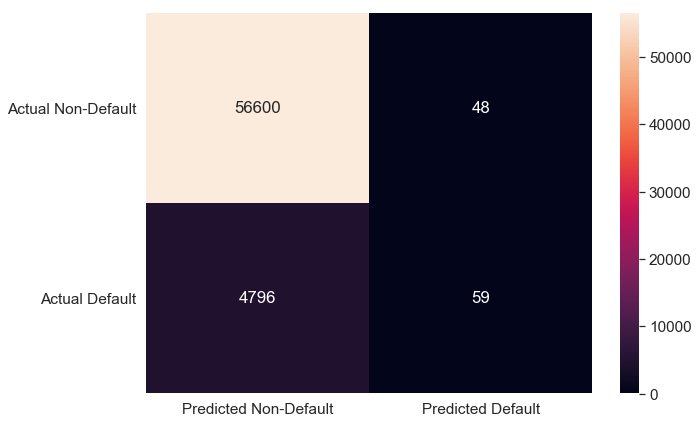



Test Data ROC Curve



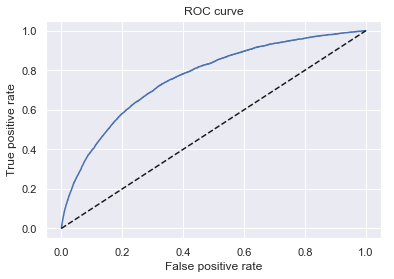

Test Data AUROC

0.7641


In [41]:
lgbm_finalmodel_matrix = finalmodelperformance(150,model_lgbm_best.best_estimator_,0.5)

### Evaluating XGBoost model with best parameters with different # of top features

Printing the mean test scores for XGBClassifier model
[0.75111505 0.75103708 0.75068848 0.75010476 0.74565404 0.74151703
 0.73880193 0.7365185  0.73948902 0.73224755 0.72987853 0.7281114
 0.73492576 0.73130607 0.7310809  0.7310809  0.7506902  0.74843842
 0.7467351  0.74490598 0.73934656 0.7322288  0.72994708 0.72714024
 0.73066161 0.72501857 0.72487322 0.72487322 0.73076266 0.73072413
 0.73072413 0.73072413 0.74930209 0.74622309 0.7441387  0.74175397
 0.73751572 0.72849668 0.7257727  0.72399533 0.72736428 0.72377816
 0.72377816 0.72377816 0.7300253  0.7300253  0.7300253  0.7300253
 0.74711742 0.74182208 0.7390659  0.73623538 0.73081025 0.7228988
 0.72159897 0.7215237  0.7225838  0.72207864 0.72207864 0.72207864
 0.72807423 0.72807423 0.72807423 0.72807423 0.75089478 0.75099718
 0.75052033 0.75003069 0.74638444 0.7422853  0.7402253  0.73785451
 0.74066686 0.73355607 0.73191882 0.73172998 0.73449807 0.73231944
 0.73231944 0.73231944 0.75054857 0.74797064 0.74632415 0.74447162
 0.73878208

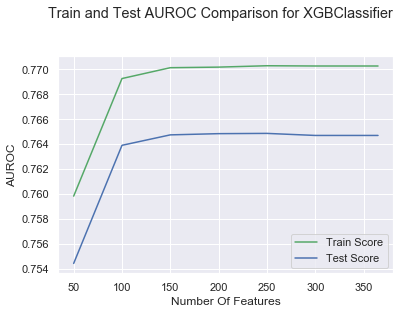

In [43]:
start_time_xgb = time.time()
modeldetails(model_xgb_best)
end_time_xgb = time.time()
time_taken_xgb = end_time_xgb - start_time_xgb
print("The total time taken to find the XGB model with the optimum # of features is --- %s seconds ---" % (time_taken_xgb))

### Running the XGBoost (with best params) with 150 top features for optimum results

Train Feature Data Shape :(246008, 150)
Test Feature Data Shape :(61503, 150)
Train Target Data Shape :(246008,)
Test Target Data Shape :(61503,)


Train Data Accuracy Score : 0.9194
Train Data Precision Score : 0.6607
Train Data Recall Score : 0.0148
Train Data F1 Score : 0.0290


Train Data Confusion Matrix



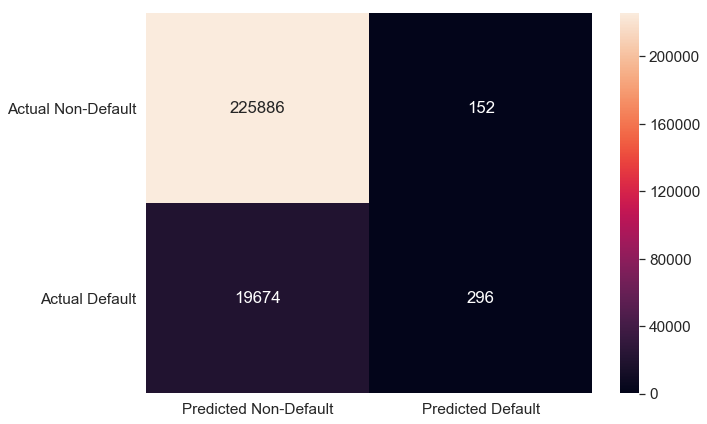



Train Data ROC Curve



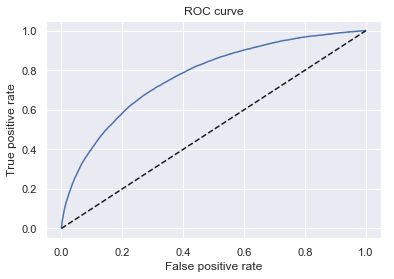

Train Data AUROC

0.7701


Test Data Accuracy Score : 0.9214
Test Data Precision Score : 0.5818
Test Data Recall Score : 0.0132
Test Data F1 Score : 0.0258


Test Data Confusion Matrix



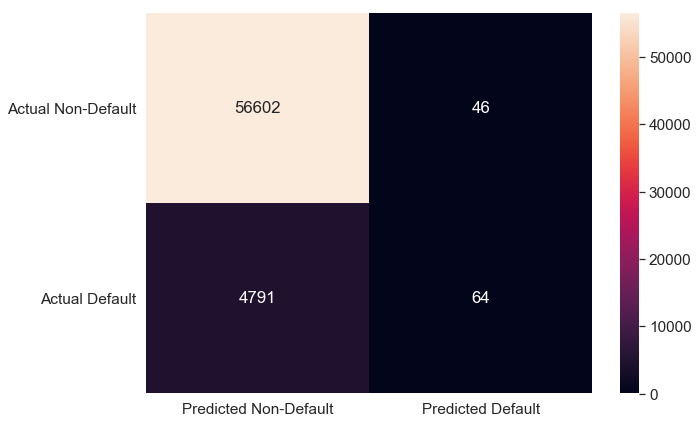



Test Data ROC Curve



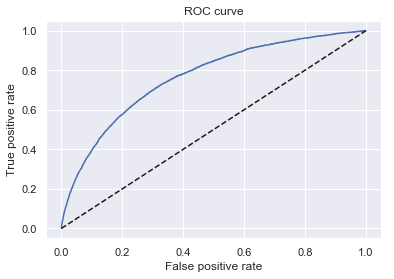

Test Data AUROC

0.7647


In [43]:
xgb_finalmodel_matrix = finalmodelperformance(150,model_xgb_best.best_estimator_,0.5)

Train Feature Data Shape :(246008, 150)
Test Feature Data Shape :(61503, 150)
Train Target Data Shape :(246008,)
Test Target Data Shape :(61503,)


Train Data Accuracy Score : 0.9194
Train Data Precision Score : 0.5434
Train Data Recall Score : 0.0449
Train Data F1 Score : 0.0829


Train Data Confusion Matrix



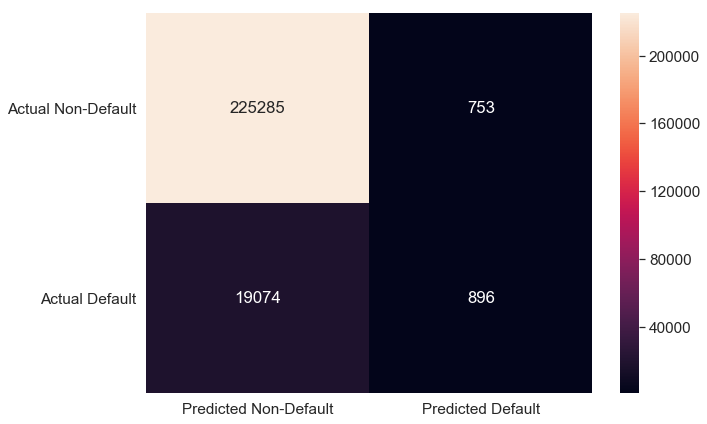



Train Data ROC Curve



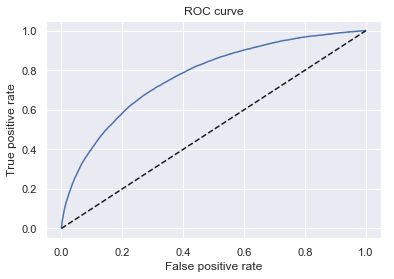

Train Data AUROC

0.7701


Test Data Accuracy Score : 0.9208
Test Data Precision Score : 0.4816
Test Data Recall Score : 0.0377
Test Data F1 Score : 0.0699


Test Data Confusion Matrix



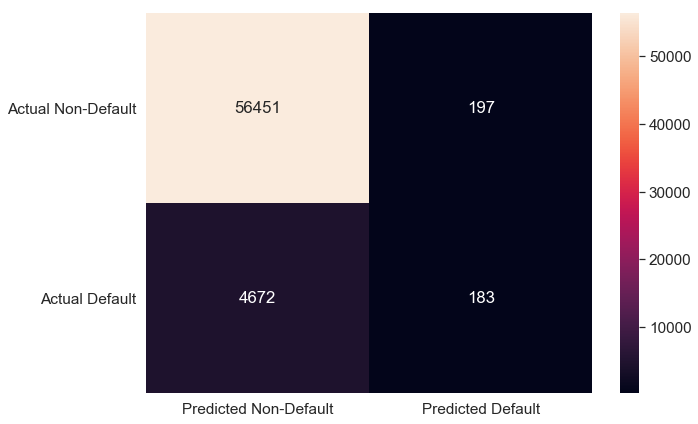



Test Data ROC Curve



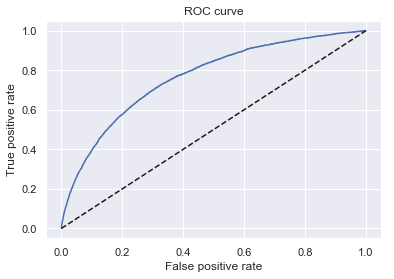

Test Data AUROC

0.7647


In [44]:
xgb_finalmodel_matrix = finalmodelperformance(150,model_xgb_best.best_estimator_,0.4)